In [1]:

import numpy as np # for data manipulation
print('numpy: %s' % np.__version__) # print version
import math # to help with data reshaping of the data

import numpy as np
import torch
#import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# from sklearn.model_selection import train_test_split
import tqdm
import matplotlib.pyplot as plt
import logging

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

numpy: 1.21.5


In [2]:
from pose_gru import PoseGRU_inputFC2

# def __init__(self, batch_size=10, input_size=3 * 21, hidden_size=512, n_layers=2, n_joint=21):
     
gru = PoseGRU_inputFC2()

In [3]:
torch.__version__

'1.10.0'

In [4]:
import os
os.chdir('../')

In [5]:
from benji_prox_dataloader import *
root_dir = 'D:/prox_data/PROXD_attempt2/PROXD'
in_frames = 10
pred_frames = 5
pd = proxDataset(root_dir, in_frames=in_frames, pred_frames=pred_frames, verbose=False)

dataloader = DataLoader(pd, batch_size=4,
                        shuffle=True, num_workers=0, collate_fn=my_collate)

In [6]:
i, in_skels, pred_skels = next(iter(dataloader))
in_skels.shape
pred_skels.shape

torch.Size([4, 10, 21, 3])

torch.Size([4, 5, 21, 3])

In [7]:
in_skels[:, 2].shape

torch.Size([4, 21, 3])

In [8]:
from pose_gru import PoseGRU_inputFC2

# def __init__(self, batch_size=10, input_size=3 * 21, hidden_size=512, n_layers=2, n_joint=21):
     
gru = PoseGRU_inputFC2()


In [9]:
cur_state, output = gru.forward_prediction(in_skels, pred_len=3)

In [11]:
cur_state.shape
len(output)

torch.Size([4, 512])

3

In [12]:
output[0].shape

torch.Size([4, 21, 3])

In [15]:
output

[tensor([[[ 0.0087, -0.0082, -0.0593],
          [-0.0623, -0.0513, -0.0104],
          [ 0.0266, -0.0343, -0.0195],
          [ 0.0887,  0.0540, -0.0569],
          [-0.1908, -0.0859,  0.0843],
          [-0.0181,  0.0034,  0.0855],
          [-0.0409, -0.0163, -0.0291],
          [ 0.0094, -0.0172, -0.0315],
          [ 0.0770, -0.0324, -0.0348],
          [ 0.0672,  0.0181, -0.0040],
          [ 0.0361,  0.1464, -0.0757],
          [ 0.0150,  0.0303, -0.0079],
          [-0.0503, -0.0265,  0.0523],
          [-0.0401,  0.0083, -0.0403],
          [ 0.1029,  0.1092, -0.0280],
          [-0.0430, -0.0362,  0.0468],
          [-0.0310, -0.0292,  0.1688],
          [-0.1236,  0.0144, -0.0191],
          [ 0.0540, -0.0295, -0.0946],
          [ 0.0573, -0.0199,  0.0477],
          [ 0.0282, -0.0270,  0.0450]],
 
         [[ 0.0072,  0.0280, -0.0718],
          [-0.0943, -0.0598,  0.0586],
          [-0.0179, -0.0915,  0.0364],
          [ 0.1414,  0.1104, -0.0350],
          [-0.2241, -0

In [22]:
output[0].view((1,) + output[0].shape).shape

torch.Size([1, 4, 21, 3])

In [23]:
pred_skels = torch.cat([tens.view((1,) + tens.shape) for tens in output])
pred_skels = pred_skels.transpose(0, 1)

torch.Size([3, 4, 21, 3])

In [13]:
temp = torch.tensor(output).transpose(0, 1)

ValueError: only one element tensors can be converted to Python scalars

In [5]:
class MockupModel(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: np.ndarray, seq_len):
        super().__init__()

        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.input_size = input_size
        self.output_size=output_size

        self.model = nn.ModuleDict({
            'lstm': nn.LSTM(input_size=np.product(input_size), hidden_size=hidden_size, num_layers=num_layers, batch_first=True),
            'linear': nn.Linear(in_features=hidden_size*seq_len, out_features=np.product(output_size))})  # is this correct?l
    def forward(self, input):
        # From [batches, seqs, seq len, features]
        # to [seq len, batch data, features]
        logging.debug(f'input: {input.shape}')
        input = input.reshape(-1, self.seq_len, self.input_size)
        logging.debug(f'input trans: {input.shape}')

       
        # Data is fed to the LSTM
        out, (h_n, c_n) = self.model['lstm'](input)
        logging.debug(f'h_n: {h_n.shape}; c_n: {c_n.shape}')
        logging.debug(f'lstm out: {out.shape}')


        # in_bs = input.shape[1]
        out = out.reshape(-1, self.seq_len*self.hidden_size)
        logging.debug(f'linear in: {out.shape}')
        out = self.model['linear'](out)
        logging.debug(f'linear out: {out.shape}')
        return out.reshape((-1,) + self.output_size)


In [9]:
criterion = nn.MSELoss()
learning_rate=0.00001
losses = []
losses_rep = []

# rnn = MockupModel(input_size=21*3, hidden_size=50, num_layers=2, output_size=(pred_frames, 21, 3), seq_len=in_frames)
gru = PoseGRU_inputFC2()


n_iter = 1
bs = 30
i = 0

for i, (indices, in_skels, fut_skels) in tqdm.tqdm(enumerate(dataloader)):
    cur_state, pred_skels = gru.forward_prediction(in_skels, pred_len=pred_frames)
    loss = criterion(pred_skels, fut_skels)
    loss.backward()
    #repeat_pred = 

    rep_pred = in_skels[:, -1, :, :]
    rep_pred = rep_pred.tile(pred_frames, 1, 1, 1).transpose(0, 1)
    loss_rep = criterion(rep_pred, fut_skels)
    losses_rep.append(loss_rep)

    for p in gru.parameters():
        _ = p.data.add_(p.grad.data, alpha=-learning_rate)
    losses.append(loss.item())
    # print(i, loss)


plt.plot(losses)
print(losses[-4:])

11it [00:09,  1.13it/s]


KeyboardInterrupt: 

In [74]:
in_skels.shape

torch.Size([4, 10, 21, 3])

In [10]:
losses_rep[-10:]

[tensor(0.0025),
 tensor(0.0084),
 tensor(0.0049),
 tensor(0.0159),
 tensor(0.0022),
 tensor(0.0269),
 tensor(0.0107),
 tensor(0.0064),
 tensor(0.0034),
 tensor(0.0014)]

In [8]:
np.mean(losses_rep)

0.008450109

In [11]:
from scipy.ndimage import gaussian_filter

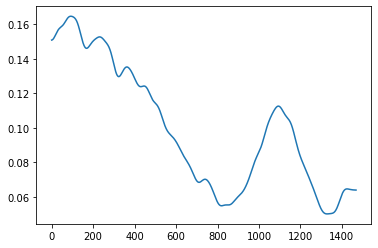

In [12]:
plt.plot(gaussian_filter(losses, sigma=20))

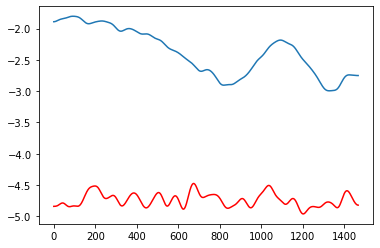

In [13]:
plt.plot(np.log(gaussian_filter(losses, sigma=20)))
plt.plot(np.log(gaussian_filter(losses_rep, sigma=20)), color='red')

In [55]:
torch.min(in_skels)
torch.max(in_skels)
torch.min(pred_skels)
torch.max(pred_skels)

tensor(-1.0774)

tensor(1.2864)

tensor(-1.2333)

tensor(1.4083)

In [14]:
in_skels.shape
in_skels[0, -2, :6]
in_skels[0, -1, :6]
pred_skels[0, 0, :6]

torch.Size([4, 10, 21, 3])

tensor([[-0.3179, -0.1304, -0.0090],
        [-0.3812,  0.0191, -0.0526],
        [ 0.2820, -0.0099,  0.0138],
        [ 0.1667, -0.0873,  0.0161],
        [ 1.2000, -0.1086,  0.0210],
        [-0.1702, -0.0049,  0.0140]])

tensor([[-0.3633, -0.1326,  0.0189],
        [-0.4161,  0.0095, -0.0526],
        [ 0.2898, -0.0135,  0.0326],
        [ 0.3231, -0.0691, -0.0657],
        [ 1.2414, -0.0815,  0.1173],
        [-0.2037, -0.0064,  0.0075]])

tensor([[-0.2784,  0.0358,  0.0542],
        [-0.3149, -0.0151, -0.0153],
        [ 0.2918,  0.1655,  0.1089],
        [ 0.3239,  0.0657, -0.0652],
        [ 0.4129, -0.0502,  0.0414],
        [-0.0822, -0.1353, -0.0549]], grad_fn=<SliceBackward0>)

In [60]:
in_skels.shape
in_skels[0, -2, :6]
in_skels[0, -1, :6]
pred_skels[0, 0, :6]

torch.Size([4, 10, 21, 3])

tensor([[ 0.3130,  0.0455, -0.0652],
        [-0.5712,  0.0728,  0.0162],
        [ 0.2158, -0.1059, -0.0386],
        [-0.0323, -0.1706,  0.0347],
        [ 0.4868, -0.0944, -0.0178],
        [-0.0655, -0.0543,  0.0548]])

tensor([[ 0.3192,  0.0343, -0.0728],
        [-0.5910,  0.0802,  0.0175],
        [ 0.2021, -0.1082, -0.0371],
        [ 0.0180, -0.1868,  0.0386],
        [ 0.5461, -0.0984, -0.0153],
        [-0.0772, -0.0501,  0.0588]])

tensor([[ 0.3029,  0.0263, -0.0564],
        [-0.6359,  0.0879,  0.0205],
        [ 0.2078, -0.1110, -0.0400],
        [ 0.0894, -0.1865,  0.0362],
        [ 0.6398, -0.0971, -0.0101],
        [-0.0926, -0.0507,  0.0598]])

In [50]:
xin = df2.MedTemp[:7].array
def predict(xin):
    # hidden = rnn.initHidden()
    out = rnn(torch.tensor(xin).float().reshape(1, -1))
    yout = out.detach().numpy()
    return yout




<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

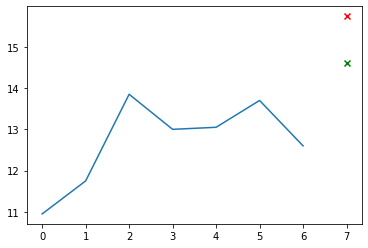

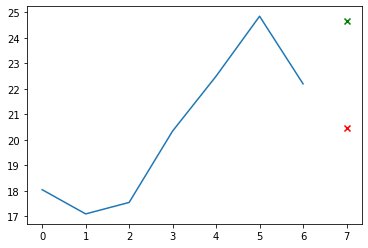

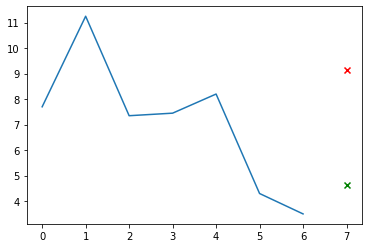

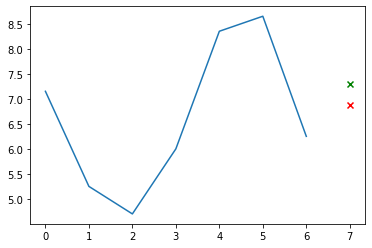

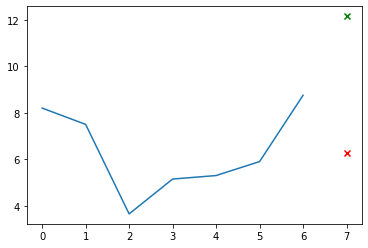

In [51]:
def plot(xin, ypred, ytrue):
    plt.plot(xin)
    plt.scatter(len(xin), ypred, color='r', marker='x')
    plt.scatter(len(xin), ytrue, color='g', marker='x')


for i in range(10, 15):
    xin = X_test[i]
    ypred = predict(xin)
    ytrue = Y_test[i]
    plt.figure()
    plot(xin, ypred, ytrue)


In [50]:
xin

<PandasArray>
[             16.15,              20.45, 18.549999999999997,
               14.4, 11.850000000000001, 11.549999999999999,
 12.149999999999999]
Length: 7, dtype: float64

In [ ]:
3